### Replication Jeong 2012
In this notebook we aim to replicate the simulations performed in "A CONSISTENT NONPARAMETRIC TEST FOR CAUSALITY IN QUANTILE" by Jeong, Kiho and Härdle, Wolfgang K and Song, Song.

#### 1. Data generation
We start by generating a bivariate dataset
$\{y_t, w_t \}^{T}_{t=1}$ according to the following model:
$$y_t = \frac{1}{2}y_{t-1} + cw_{t-1}^{2} + \epsilon_{1, t}$$
$$w_t = 1 + \frac{1}{2}w_{t-1} + \epsilon_{2, t}$$
Here $c = 0$ corresponds to the hypothetical model; that is, $w_t$ does not cause $y_t$ in the $\theta$ quantile with respect to $\{ y_{t−1},w_{t−1} \}$.
Different values of $c$ are used, such that the higher $c$ is, the stronger the causality of $w_t$ on $y_t$.

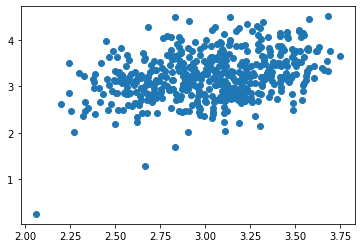

In [2]:
import numpy as np
import matplotlib.pyplot as plt

T = 501
c = 0.12

# initialise empty vectors
y, w = np.random.rand(T), np.random.rand(T)

# fill vectors with data according to the models specified above
for i in range(T-1):
    w[i+1] = 1 + 0.5*w[i] + np.random.rand(1)
    y[i+1] = 0.5*y[i] + c * w[i]**2 + np.random.rand(1)

y, w = np.delete(y, 0), np.delete(w,0)

plt.scatter(w,y)

#### 1a. Defining information sets
$$x_t = (y_{t-1} \dots y_{t-p}), \quad z_t = (y_{t-1} \dots y_{t-p}, w_{t-1} \dots w_{t-q})$$
In our simulation case both $p$ and $q$ are 1

In [10]:
def x_t(y, i):
    return y[i-1]

def z_t(y, w, i):
    return (y[i-1], w[i-1])

#### 1b. Conditional quantiles
$$Q_{\theta}(z_t) = Q_{\theta}(y_t | z_t), \quad Q_{\theta}(x_t) = Q_{\theta}(y_t | x_t)$$ 
Where $Q_{\theta}(y_t|\cdot)$ is the $\theta$th conditional quantile of $y_t$ given $\cdot$

#### $Q_{\theta}(y_t | x_t)$

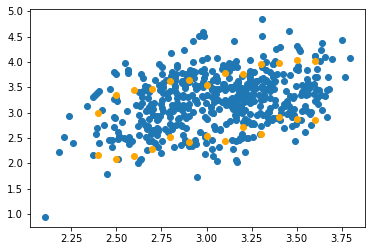

In [60]:
# The 0.05 and 0.95 quantile of y_t given x_t
def y_tConx_t(y, x):
    results = []
    for i, y_i in enumerate(y):
        if round(y_i, 1) == round(x, 1) and len(y) > i+1:
            results.append(y[i+1])
    
    return results

def q_y_t(y, x, q=[0.05, 0.95]):
    # 1. Get all values of y_t for a given x_t: x
    y_t = y_tConx_t(y, x)
    
    # print(x, ": ", y_t)
    # 2. Get the specific quantile of y_t given some x_t: x
    return np.quantile(y_t, q)

plt.scatter(w, y)
for i in np.arange(2.4, 3.6, 0.1):
    plt.scatter([i, i], q_y_t(y, round(i, 1)), color='orange')

#### $Q_{\theta}(y_t | z_t)$

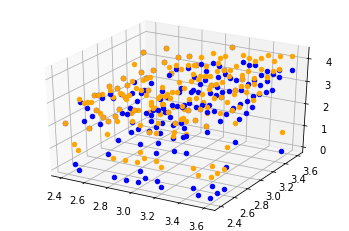

In [61]:
# The 0.05 and 0.95 quantile of y_t given z_t

def y_tConz_t(y, w, z):
    results = []
    for i, (y_i, w_i) in enumerate(zip(y, w)):
        if round(y_i, 1) == round(z[0],1) and round(w_i, 1) == round(z[1],1) and len(y) > i+1:
            results.append(y[i+1])
    
    if len(results) == 0:
        results.append(0)
        results.append(1)
        
    return results


def q_y_t(y, x, z, q=[0.05, 0.95]):
    # 1. Get all values of y_t for a given z_t: (x, y)
    y_t = y_tConz_t(y, x, z)
    
    # print(x, ": ", y_t)
    # 2. Get the specific quantile of y_t given some z_t: (x, y)
    return np.quantile(y_t, q)


# Here we get all 0.05Q and 0.95Q conditionaly on every y_t and w_t
condQ = []
# for each given value of y_t
for y_t in np.arange(2.4, 3.6, 0.1):
    # for each given value of w_t
    for w_t in np.arange(2.4, 3.6, 0.1):
        condQ.append([[round(y_t,1), round(w_t,1)], q_y_t(y, w, [y_t, w_t])])

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Pretty print to show intuition
for i in range(0, len(condQ)):
    # print("Given (y_t, w_t): (", condQ[i][0][0],", ",condQ[i][0][1],") => Q.05: ",condQ[i][1][0], " Q.95: ",condQ[i][1][1])
    ax.scatter(condQ[i][0][0], condQ[i][0][1], condQ[i][1][0], color='blue')
    ax.scatter(condQ[i][0][0], condQ[i][0][1], condQ[i][1][1], color='orange')

#### 1c. Conditional distributions
Lets plot the conditional distribution function of $y_t$ given $z_t(x_t)$ which is (mathmatically) equivalent to:
$$ F_{y_t|z_t} (y_t|z_t) (F_{y_t|x_t}(y_t|x_t)) $$

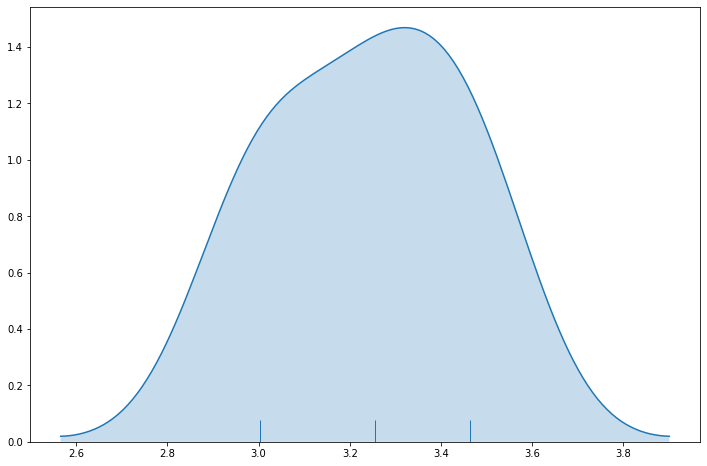

In [62]:
import seaborn as sns
from scipy import stats

# We plot the condition distribution for z_t = (3, 3)
y_t = y_tConz_t(y, w, (3,3))

fig, ax = plt.subplots(figsize=(12,8))
sns.kdeplot(y_t, shade=True) # use kernel density estimation
sns.rugplot(y_t)
# Hoe kunnen we dit interpreteren?

### 2. Test Statistic
We have with probability 1 that:
$$F_{y|z} \{ Q_{\theta}(z_t) | z_t \} = \theta, \quad F_{y|z} \{ Q_{\theta}(y_t | z_t) | z_t \} = \theta$$
$$ \text{Note}: z_t = (y_{t-1} \dots y_{t-p}, w_{t-1} \dots w_{t-q}), \quad z_t = (y_{t-1}, w_{t-1})$$

<span style="color:red">
    Intuitively this means?? <br />
    In essentie zegt dit dat we 100% zeker zijn dat de kans dat een bepaalde waarde $y_t$ in het $\theta$th quantile ligt van de informatie set $z_t$ $\theta$ is. <br />
    $\rightarrow$ Wat heel logisch is, anders zou het niet het $\theta$th quantile zijn
</span> </br>

The hypothesis to be tested are:

$$H_0: P \{ F_{y|z} ( Q_{\theta}(x_t) | z_t) = \theta \} = 1$$
$$H_1: P \{ F_{y|z} ( Q_{\theta}(x_t) | z_t) = \theta \} < 1$$

</br>
<span style="color:red">
    Intuitively this means?? <br />
    Gegeven de informatieset $x_t$ (alleen lags van $y_t$ zelf), als de kans dat een waarde $y_t$ in de $\theta$th quantile valt 1 is dan zegt ons dit dat er geen andere variabele uit de informatieset $z_t$ bestaan die $y_t$ veroorzaken. <br />
    $\rightarrow$ Als deze kans kleiner is dan 1, dan geeft ons dit dat er variabele(n) uit informatieset $z_t$ bestaan die $y_t$ veroorzaakt maar niet bestaan in de subset $x_t$.
</span> </br>
</br>

We consider the following distance measure to consistently test the hypothesis:

$$ J = E [ \{ F_{x|y}(Q_\theta(x_t)|z_t) - \theta \} ^2 f_z(z_t)]$$
With $f_z(z_t)$ being the marginal density function of $z_t$
</br>
<span style="color:red">
    Intuitively this means?? <br />
    De $J$ statistic geeft ons de proportionele afstand ($f_z(z_t)$) van de kans dat $y_t$ in de $\theta$th quantile ligt. <br />
    $\rightarrow$ Note: $J \geq 0$ alleen als $H_0$ voldoet.  
</span> </br>
</br>

Because we have $E(\epsilon_t | z_t) = F_{x|y}(Q_\theta(x_t)|z_t) - \theta$ we can write $J$ as:

$$ J = E [ \epsilon_t E(\epsilon_t | z_t) f_z(z_t)] $$

The density-weighted conditional expectation $E(\epsilon | z) f_z(z_t)$ can be estimated by kernel methods:
$$ \hat{E}(\epsilon | z) \hat{f}_z (z_t) = \frac{1}{(T-1)h^m} \sum_{t=1}^{T} K_{ts} \epsilon_s $$

Then the sample analogue of $J$ becomes:

$$
J_t = \frac{1}{T(T-1)h^m} \sum_{t=1}^{T} \sum_{s \neq t}^{T} K_{ts} \epsilon_t \epsilon_s, \quad K_{ts} = K{(z_t - z_s) / h}
\tag{1}
$$

De error term $\epsilon_t$ wordt geschat door:
$$\hat{\epsilon}_{t} = 1 \{ y_t \leq Q_{\theta}(x_t) \} - \theta$$
waar $x_t$ de informatie set is tot $t$ is met respect to quantile $\theta$

De error term $\epsilon_s$ wordt geschat door:
$$\hat{\epsilon}_{s} = 1 \{ y_s \leq Q_{\theta}(x_s) \} - \theta$$


In [4]:
from scipy import stats

# Define the kernel function (here we use a Gaussian)
def K_ts(z_t, z_s, h):
    return stats.norm.pdf((z_t - z_s) / h)

# Calculate the residuals (error)
def resid(y, x, q):
    if y <= x:
        return 1 - q
    else:
        return 0 - q

In [72]:
def J_t(T, Z, h, q, y):
    total = 0
    for t in range(T-1):
        # Get the conditional distribution of y_t given x_t
        𝑄𝑥𝑡 = y_tConx_t(y, y[t])
        
        # Get the 𝜃th quantile
        𝑄𝜃_𝑥𝑡 = np.quantile(𝑄𝑥𝑡, q)
        
        # Get the residual 𝜖_t for y_t
        𝜖_t = resid(y[t], 𝑄𝜃_𝑥𝑡, q)
        
        for s in range(T-1):
            if s == t:
                continue
                
            # Get the kernel estimate
            Kts = K_ts(Z[t], Z[s], h)
            
            # Get the conditional distribution of y_s given x_s
            𝑄𝑥𝑠 = y_tConx_t(y, y[s])
        
            # Get the 𝜃th quantile
            𝑄𝜃_𝑥𝑠 = np.quantile(𝑄𝑥𝑠, q)

            # Get the residual 𝜖_t for y_t
            𝜖_s = resid(y[s], 𝑄𝜃_𝑥𝑠, q)
        
            total += Kts * 𝜖_t * 𝜖_s
    return (1 / (T * (T -1) * h**2)) * total

res = J_t(T, np.array((y,w)).T, 0.5, 0.1, y)
print(res) # [0.00833676 0.00771059] ???

[0.00833676 0.00771059]


<span style="color:red">
     Er zijn echter maar weinig observaties om de conditionele distributie van $y_t$ te genereren voor een bepaalde waarde $z_t$, laat staan een specifieke quantile $\theta$ van deze distributie. Daarom kan de conditionele quantile distributie het best worden geschat.
</span> </br>

#### 2c. Estimate of $\theta$th conditional quantile of $y_t$ given $x_t$ ($\hat{Q}_{\theta}(x_t)$)
$\hat{Q}_{\theta}(x_t)$ is an estimate of the $\theta$th conditional quantile of $y_t$ given $x_t$ and we estimate it using the nonparametric kernel method as:
$$ \hat{Q}_{\theta}(x_t) = \hat{F}^{-1}_{y_t|x_t}(\theta|x_t) $$
where $\hat{F}_{y_t|x_t}(y_t|x_t)$ is the Nadaraya-Watson kernel estimator. Which is defined as:
$$\hat{F}_{y_t|x_t} (y_t|x_t) = \frac{\sum_{s \neq t}^T L ((x_t - x_s)/h) 1(y_s \leq y_t)}{\sum_{s \neq t}^T L ((x_t - x_s)/h)}$$

**Note**:
- $x_t = y_{t-1}$ => size: $p$x1 (Because we only use one lag ($p$= 1))
- $x_s = y_{t-s}$ => size: $p$x1 ($p >1$??)
- $y_t$ = entire sample => size: $T$x1
- $y_s$ = ??

In [190]:
from scipy import stats
import seaborn as sns
from scipy import stats

# Create a general indicator function
def I(y_s, y_t):
    if y_s <= y_t:
        return 1
    else:
        return 0
    
# Create a general indicator function
def I_(a,b):
    res = []
    for i in range(len(b)):
        if a <= b[i]:
            res.append(1)
        else:
            res.append(0)
    return res
        
def NWm(t, X, Y, h):
    som_nom = 0
    som_denom = 0

    for s in range(T-2):
        som_nom += np.dot(K_ts(X[t], X[s], h), I_(Y[s+1], Y))
        som_denom += K_ts(X[t], X[s], h)
                                     
    return som_nom / som_denom

res = NWm(50, y, y, 0.5) # res is a 500x1 vector where each row represents the probability of finding a value y_t given x_t in the row

'Res (q=0.5): 0.648805601891881'

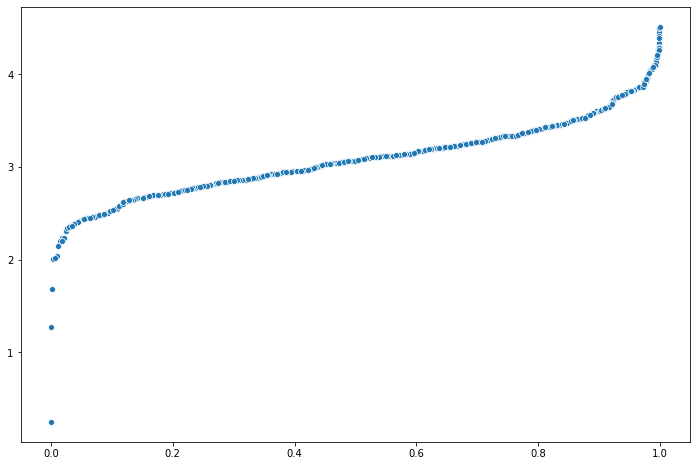

In [202]:
fig, ax = plt.subplots(figsize=(12,8))
# sns.kdeplot(a/b, shade=True) # use kernel density estimation
# sns.rugplot(a/b)
sns.scatterplot(res, y) # use kernel density estimation
# sns.scatterplot(np.quantile(np.sort(res), 0.1))
# sns.kdeplot(res*y)
# sns.rugplot(res*y)
q = 0.5
stats.norm.ppf(np.quantile(res, 0.5))
f'Res (q={q}): {np.quantile(res, 0.5)}'

In [189]:
# 0.96496029846082
y[50]

2.788053514207021

In [118]:
# K_ts(y[49], y[50], 0.5)
a = stats.norm.pdf((y - y[50]) / 0.5) * [I(y[s], y[51]) for s in range(T-1)]

som = 0
for i in range(500):
    if i == 50:
        continue
    else:
        som += stats.norm.pdf((y[50] - y[i]) / 1)
        
np.random.normal(res)

0.908298982902152

In [111]:

a = (y[51] - y[50]) / 0.5
stats.norm.pdf((y[51] - y[50]) / 0.5) + stats.norm.pdf((y[50] - y[51]) / 0.5)

0.7662648324850788

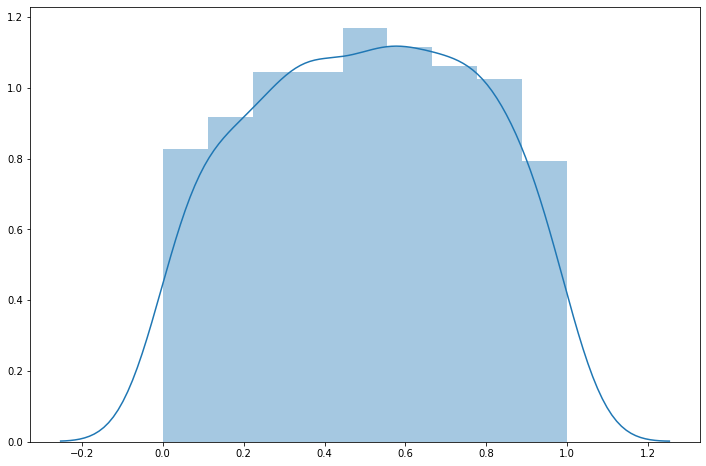

In [10]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(res)

In [119]:
y[: None]

array([0.24658005, 1.27151114, 2.23035573, 3.1002013 , 2.44684735,
       2.43235974, 2.95694314, 2.19864663, 2.46268259, 2.40024295,
       2.87004169, 2.90486332, 3.33618244, 3.84457376, 4.50370122,
       4.09130271, 3.99794258, 3.44372205, 3.33678711, 3.72511973,
       3.15118843, 2.6991785 , 2.72019223, 2.81609217, 3.13010586,
       3.03486354, 2.68113985, 3.26581749, 3.37290837, 3.22484744,
       3.27223143, 3.60100497, 3.49068717, 3.53293778, 3.76021053,
       3.98793348, 4.14813557, 4.46249242, 4.19992626, 3.92166784,
       3.49999909, 3.31429601, 3.27614702, 3.85323964, 4.21235565,
       3.87661707, 3.29427098, 3.77647523, 3.81401531, 3.7578521 ,
       2.78805351, 2.93024367, 3.24732357, 3.05734481, 3.14033494,
       3.52373736, 3.77049987, 3.6764027 , 3.63539558, 3.79086981,
       4.09745101, 3.97650891, 3.49760156, 3.28141694, 3.25633005,
       2.98025182, 3.3365772 , 3.27194535, 3.32005984, 3.1322042 ,
       3.26368613, 3.41732186, 3.56828579, 3.81698657, 3.76173

#### Appendix A: Nadaraya-Watson estimation
The objective is to estimate a regression function $m$ non-parametrically. The Nadaraya-Watson estimate is computed as follows:
$$\hat{m}(x; 0, h) = \sum^n_{i=1} \frac{K_h (x - X_i)}{\sum^n_{i=1} K_h(x - X_i)}Y_i $$
$$\hat{m}(x; 0, h) = \sum^n_{i=1} W^0_i(x) Y_i, \quad W^0_i(x) =  \frac{K_h (x - X_i)}{\sum^n_{i=1} K_h(x - X_i)}$$

(-15.0, 15.0)

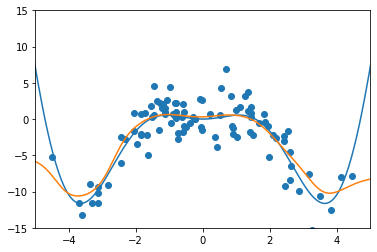

In [38]:
from scipy import stats
import matplotlib.pyplot as plt
import math

def NWm(x, X, Y, h):
    # Determine the evaluation point of each x
    Wi = lambda Xi: stats.norm.pdf((x - Xi) / h)

    # Matrix of size n x length(x)
    Kx = np.array([Wi(x_i) for x_i in X])

    # Determine weights for each evaluation point x
    W = Kx / Kx.sum(axis=0)

    # Return the 'local' weighted average of Y1,..,Yn around x
    return np.dot(np.transpose(W), Y)

# Generate some deterministic data
np.random.seed(12345)
n = 100
eps = np.random.normal(0, 2, n)

def m(x):
    return x**2 * math.cos(x)

X = np.random.normal(0, 2, n)
Y = np.array([m(e) for e in X]) + eps
xGrid = np.arange(-10, 10, 20/500)

# Set bandwidth param
h = 0.5

plt.scatter(X, Y)
plt.plot(xGrid, np.array([m(e) for e in xGrid]))
plt.plot(xGrid, NWm(xGrid, X, Y, h))
plt.xlim(-5, 5)
plt.ylim(-15, 15)

In [48]:
# Dirty
from scipy import stats
import matplotlib.pyplot as plt
import math

# Create a general indicator function
def I_(a,b):
    res = []
    for i in range(len(a)):
        if a[i] <= b:
            return 1
        else:
            return 0
    return res
        
def NWm(x, X, Y, h):
    # x_s = np.delete(X, t-p)
    # y_s = np.delete(Y, t)
    
    # Determine the evaluation point of each x
    Wi = lambda x_s: stats.norm.pdf((x - x_s) / h)

    # Matrix of size n x length(x)
    Kx = np.array([Wi(X[i]) for i in range(len(X))])

    Y_ = [I_(Y, y_s) for y_s in Y]
    # Determine weights for each evaluation point x
    W = (Kx * Y_) / Kx.sum(axis=0)
    return W
    # Return the 'local' weighted average of Y1,..,Yn around x
    # return np.dot(W, Y)

xGrid = np.arange(1, 4, 3/500)
res = NWm(xGrid, y, y, 0.9)

In [61]:
# y_50 = 2.788053514207021
# y_51 = 2.9302436721548033
ans = np.quantile(np.multiply(res[50], y), 0.1)
# pr = np.dot(res, y)
# sns.scatterplot(res, y)
# pr
np.sort(res[50])[0:50]

array([0.00123072, 0.00123635, 0.001242  , 0.00124765, 0.00125332,
       0.001259  , 0.0012647 , 0.0012704 , 0.00127612, 0.00128185,
       0.00128759, 0.00129335, 0.00129911, 0.00130489, 0.00131068,
       0.00131648, 0.0013223 , 0.00132812, 0.00133396, 0.00133981,
       0.00134567, 0.00135154, 0.00135742, 0.00136331, 0.00136922,
       0.00137513, 0.00138106, 0.001387  , 0.00139295, 0.00139891,
       0.00140488, 0.00141086, 0.00141685, 0.00142285, 0.00142886,
       0.00143488, 0.00144092, 0.00144696, 0.00145301, 0.00145907,
       0.00146515, 0.00147123, 0.00147732, 0.00148342, 0.00148954,
       0.00149566, 0.00150179, 0.00150793, 0.00151408, 0.00152023])

Conditional distribution of y_t given x0 (0.398)


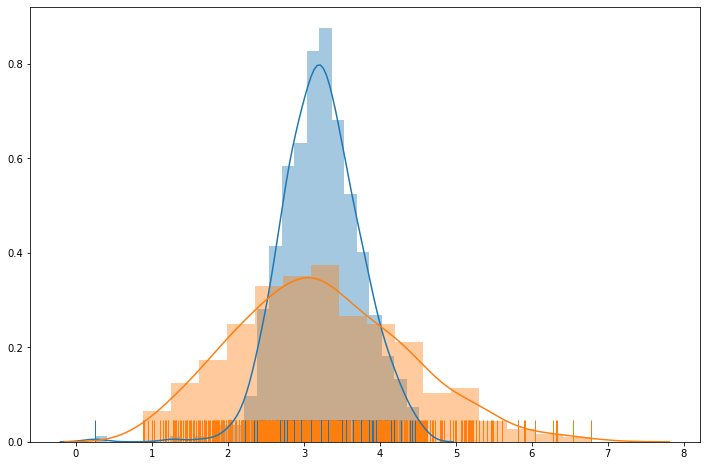

In [50]:
import seaborn as sns
from scipy import stats

x = res
print("Conditional distribution of y_t given x0 (0.398)")
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(y, hist=True, kde=True, rug=True) # use kernel density estimation
sns.distplot(pr, hist=True, kde=True, rug=True) # use kernel density estimation


In [37]:
print("Es. y_t:", pr, " for y_t-1 of: ", y[50])

Es. y_t: 3.941865930046695  for y_t-1 of:  2.788053514207021


#### Using Statsmodels KernelReg

In [73]:
from statsmodels.nonparametric.kernel_regression import KernelReg

Y = Y[:-1]
X = Y[0:]

nw = KernelReg(Y, X, 'c', reg_type='ll')
res = nw.fit()

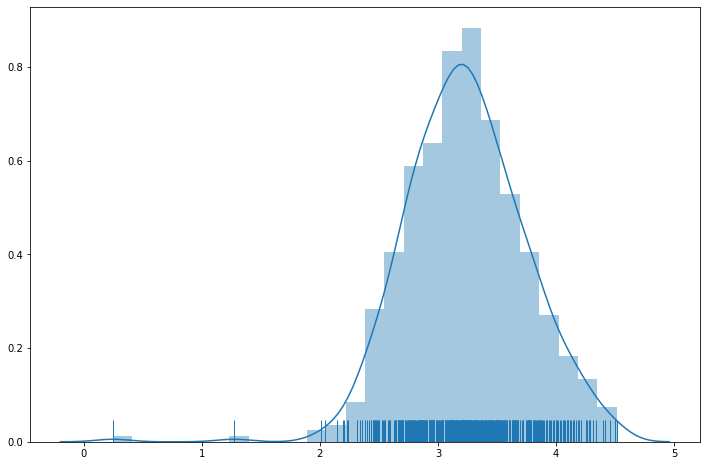

In [74]:
fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(res[0], hist=True, kde=True, rug=True)

In [75]:
a = np.quantile(res[0], 0.1)

In [77]:
1/a

0.3759252225824364